# 0. Imports & functions

In [1]:
import sys

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/telco_churn.csv")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/telco_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
# df = pd.read_csv(RAW_DATA_PATH)
# df = df.rename(columns=dict(
#     zip(df.columns, list(map(to_snake_case, df.columns)))))

# print(df.shape[0])
# df.churn.value_counts()/df.shape[0]*100

In [4]:
y = "customer_status"

# some generic cleaning
df["avg_monthly_long_distance_charges"] = df["avg_monthly_long_distance_charges"].fillna(0.0)
df["multiple_lines"] = df["multiple_lines"].fillna('no phone service')
df["avg_monthly_gb_download"] = df["avg_monthly_gb_download"].fillna(0)
no_internet = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv','streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet] = df[no_internet].fillna('no internet service')
COLUMNS_TO_DROP = ["customer_id", "churn_category","churn_reason", "longitude", "latitude", "city"]
df = df[df[y] != "Joined"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [5]:
pd.set_option('display.max_columns', None)

# df.internet_type.isna().sum()
df.head()


,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


# 2. Model selection

## Logistic Regression

In [6]:
df[y].value_counts()/len(df)

customer_status
Stayed     0.716345
Churned    0.283655
Name: count, dtype: float64

In [7]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = "logistic"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name=MODEL_NAME, param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1260 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^

Best score: 0.9138689812602856
Best parameters: {'logistic__C': 10, 'logistic__penalty': 'l2', 'over__sampling_strategy': 0.7, 'pca__n_components': 50, 'under__sampling_strategy': 0.5}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'streaming_music',
                                                   'unlimited_data', 'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('over', SMOTE(sampling_strategy=0.7)),
                ('pca', PCA(n_components=50)),
                ('logistic', LogisticRegression(C=10))])

In [8]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [9]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
29,0.5,0.7,15,1,l2,0.874868,0.007190
113,0.5,0.7,15,10,l2,0.874386,0.007543
197,0.5,0.7,15,100,l2,0.874920,0.007284
281,0.5,0.7,15,1000,l2,0.874757,0.007652
33,0.5,0.7,20,1,l2,0.874891,0.006731
...,...,...,...,...,...,...,...
330,0.7,1.0,50,1000,l2,0.912164,0.006401
82,0.7,1.0,65,1,l2,0.912835,0.005067
166,0.7,1.0,65,10,l2,0.912255,0.006500
250,0.7,1.0,65,100,l2,0.913440,0.006160


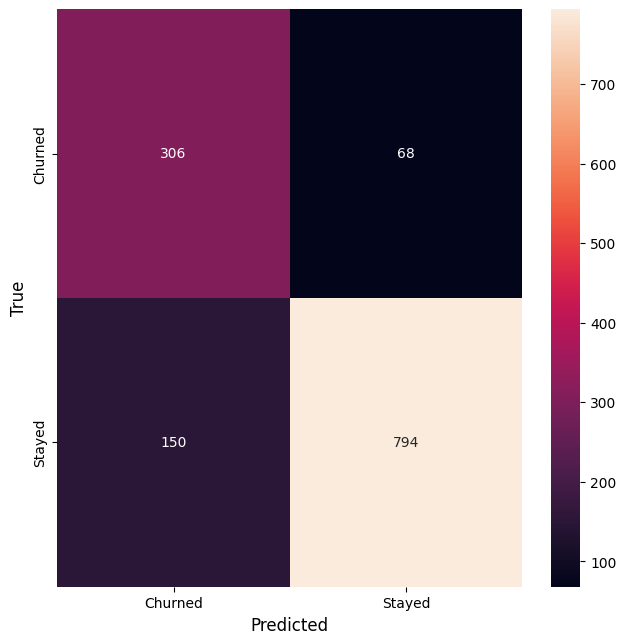

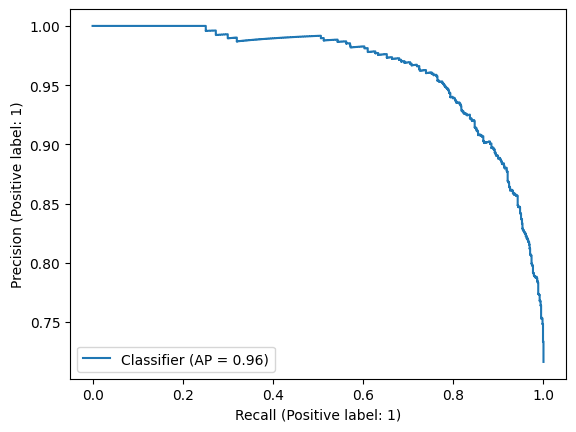

In [10]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [11]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized=True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.894056024490807
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.5, 'pca__n_components': 15, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [12]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

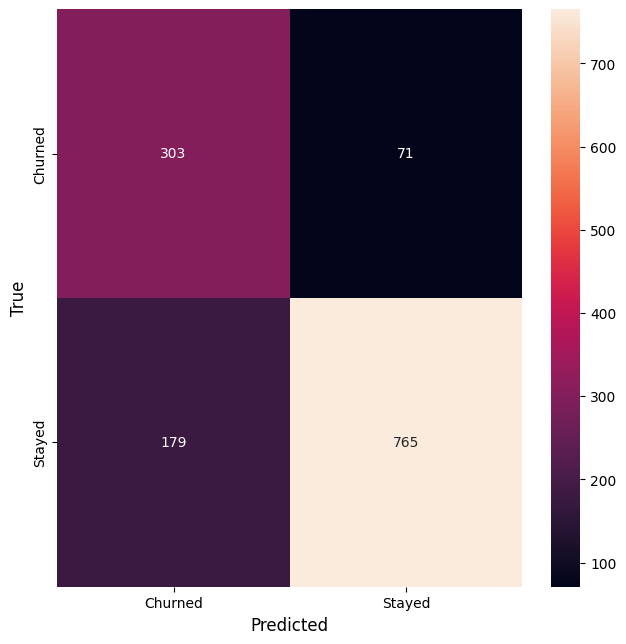

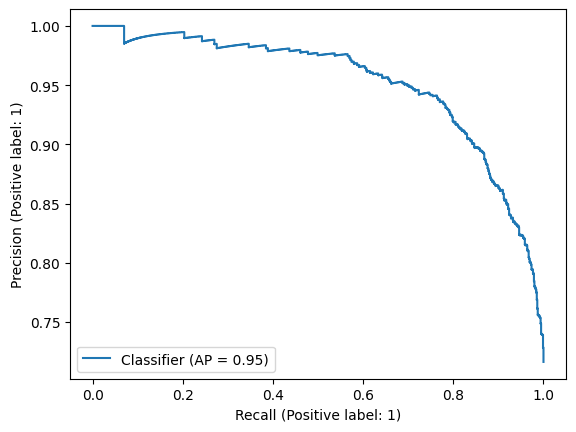

In [13]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [7]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# 3. Cost-based evaluation

In [40]:
TRUE_Y_ENCODED_COLUMN_NAME = "churn_encoded"
PREDICTED_Y_PROB_COLUMN_NAME = "y_predicted_proba_log"

In [45]:
# Define a function to calculate the instance-dependent cost

# def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
#     if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
#         return  2*a  # Switched cost for FP
#     elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
#         return 0  # Switched cost for TP
#     elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)
#         return  12*a  # Switched cost for FN
#     elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
#         return 0 # Switched cost for TN

test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log[PREDICTED_Y_PROB_COLUMN_NAME]= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
test_predictions_log[PREDICTED_Y_PROB_COLUMN_NAME] = 1 - test_predictions_log[PREDICTED_Y_PROB_COLUMN_NAME]
test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log["customer_status"])
test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["monthly_charge"]).to_frame())[:, 0]
test_predictions_log["y_predicted"] = 1 - test_predictions_log["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))



Test cost/loss = 73965.
 total cost/loss average :  56.11896813353565


In [51]:
# def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
#     if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
#         return 2 * a
#     elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
#         return 0    # Switched cost for TN
#     elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)
#         return  12 * a  # Switched cost for FP
#     elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
#         return 0

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb[PREDICTED_Y_PROB_COLUMN_NAME] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb[PREDICTED_Y_PROB_COLUMN_NAME] = 1 - test_predictions_xgb[PREDICTED_Y_PROB_COLUMN_NAME]
test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb["customer_status"])
test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["monthly_charge"]).to_frame())[:, 0]
test_predictions_xgb["y_predicted"] =  1- test_predictions_xgb["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))



Test cost/loss = 85940.
 total cost/loss average :  65.2051593323217


In [61]:
print(test_predictions_xgb[['customer_status', "A", 'instance_cost', "y_predicted"]].head(30))

     customer_status       A  instance_cost  y_predicted
4879          Stayed   67.45            0.0            0
1646          Stayed   69.65            0.0            0
777           Stayed   20.10            0.0            0
1163          Stayed   54.75            0.0            0
130           Stayed   48.80            0.0            0
3765         Churned   80.35          964.2            0
2533         Churned   75.30            0.0            1
1837          Stayed   19.90            0.0            0
302           Stayed   20.05            0.0            0
768           Stayed   39.40            0.0            0
1695         Churned   91.00         1092.0            0
1366         Churned   49.05          588.6            0
1058          Stayed   99.00            0.0            0
2474         Churned   86.20            0.0            1
1141          Stayed   19.80            0.0            0
2348          Stayed   19.95            0.0            0
2971         Churned   79.65   

# 3.1 AMC evaluation metric

# 3.1 AMC evaluation metric

In [47]:
test_predictions_log[PREDICTED_Y_PROB_COLUMN_NAME]

4879    0.249157
1646    0.020225
777     0.076730
1163    0.082671
130     0.021864
          ...   
5340    0.162799
2641    0.903085
5796    0.918651
36      0.637971
5716    0.151984
Name: y_predicted_proba_log, Length: 1318, dtype: float64

In [38]:
test_predictions_log[[]"PREDICTED_Y_PROB_COLUMN_NAME"]

4879    0.750843
1646    0.979775
777     0.923270
1163    0.917329
130     0.978136
          ...   
5340    0.837201
2641    0.096915
5796    0.081349
36      0.362029
5716    0.848016
Name: y_predicted_proba_log, Length: 1318, dtype: float64

Decision Threshold: 0.01, Test cost/loss = 94764.20
Decision Threshold: 0.02, Test cost/loss = 85665.50
Decision Threshold: 0.03, Test cost/loss = 78860.70
Decision Threshold: 0.04, Test cost/loss = 74284.90
Decision Threshold: 0.05, Test cost/loss = 70939.20
Decision Threshold: 0.06, Test cost/loss = 69983.70
Decision Threshold: 0.07, Test cost/loss = 69240.80
Decision Threshold: 0.08, Test cost/loss = 67218.60
Decision Threshold: 0.09, Test cost/loss = 66394.60
Decision Threshold: 0.10, Test cost/loss = 66475.30
Decision Threshold: 0.11, Test cost/loss = 64532.20
Decision Threshold: 0.12, Test cost/loss = 62757.40
Decision Threshold: 0.13, Test cost/loss = 62876.10
Decision Threshold: 0.14, Test cost/loss = 62072.00
Decision Threshold: 0.15, Test cost/loss = 60697.40
Decision Threshold: 0.16, Test cost/loss = 59113.90
Decision Threshold: 0.17, Test cost/loss = 59327.30
Decision Threshold: 0.18, Test cost/loss = 58824.10
Decision Threshold: 0.19, Test cost/loss = 59857.00
Decision Thr

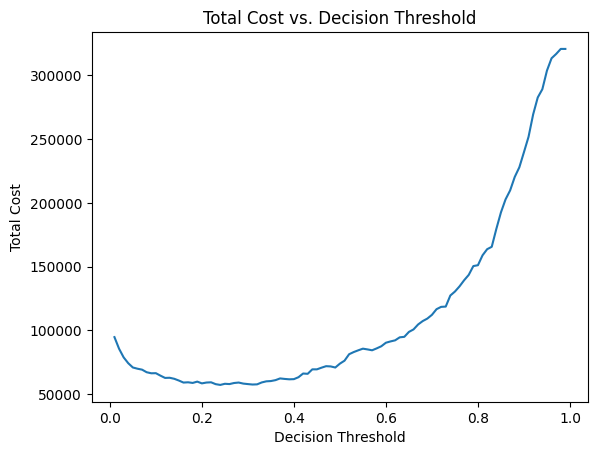

In [48]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(
    test=test_predictions_log, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=PREDICTED_Y_PROB_COLUMN_NAME)

Decision Threshold: 0.01, Test cost/loss = 104064.80
Decision Threshold: 0.02, Test cost/loss = 94865.70
Decision Threshold: 0.03, Test cost/loss = 89693.30
Decision Threshold: 0.04, Test cost/loss = 86983.30
Decision Threshold: 0.05, Test cost/loss = 85409.50
Decision Threshold: 0.06, Test cost/loss = 80950.30
Decision Threshold: 0.07, Test cost/loss = 78024.50
Decision Threshold: 0.08, Test cost/loss = 74833.30
Decision Threshold: 0.09, Test cost/loss = 72398.30
Decision Threshold: 0.10, Test cost/loss = 72423.00
Decision Threshold: 0.11, Test cost/loss = 71198.70
Decision Threshold: 0.12, Test cost/loss = 71545.50
Decision Threshold: 0.13, Test cost/loss = 69832.00
Decision Threshold: 0.14, Test cost/loss = 68119.20
Decision Threshold: 0.15, Test cost/loss = 65661.60
Decision Threshold: 0.16, Test cost/loss = 66385.20
Decision Threshold: 0.17, Test cost/loss = 65930.40
Decision Threshold: 0.18, Test cost/loss = 66574.30
Decision Threshold: 0.19, Test cost/loss = 66864.00
Decision Th

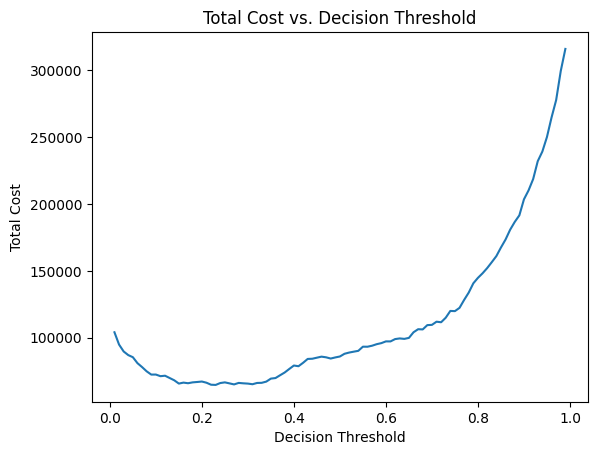

In [52]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(
    test=test_predictions_xgb, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=PREDICTED_Y_PROB_COLUMN_NAME)

In [30]:
# def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
#     thresholds = np.linspace(0.01, 0.99, 99)

#     lowest_cost = float('inf')  # Initialize with positive infinity
#     best_threshold = None
#     total_costs = []  # Store total costs for each threshold
#     test_xgb['y_predicted_proba']= xgb_best.predict_proba(test_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
#     # impute = SimpleImputer(strategy='median')
#     # test_predictions[cb_column] = impute.fit_transform(
#     # (test_predictions[cb_column]).to_frame())[:, 0]

#     for decision_threshold in thresholds:
#         test_xgb['instance_cost'] = test_xgb.apply(lambda row: instance_dependent_cost(
#             row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
#         total_cost = test_xgb['instance_cost'].sum()
#         total_costs.append(total_cost)
#         print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
#         if total_cost < lowest_cost:
#             lowest_cost = total_cost
#             best_threshold = decision_threshold

#     AMC = lowest_cost / len(test)

#     # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
#     print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

#     plt.plot(thresholds, total_costs)
#     plt.xlabel('Decision Threshold')
#     plt.ylabel('Total Cost')
#     plt.title('Total Cost vs. Decision Threshold')
#     plt.show()

#     return best_threshold, AMC, lowest_cost
# compute_best_threshold(test_xgb, best_pipeline_xgb, 'y_encoded', 'cb')

# 3.2 E-AMC evaluation metric


In [41]:
test_predictions_log = add_eap_ep(train, test_predictions_log, y, best_pipeline_log_reg, cb_column, model_name="log", instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(train, test_predictions_xgb, y, best_pipeline_xgb, cb_column, model_name="xgb", instance_dependent_cost_type="churn")

KeyError: 1

In [42]:
test_predictions_log

,gender,age,married,number_of_dependents,zip_code,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,y_encoded,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log
4879,Male,28,No,0,94612,0,40,NaN,Yes,39.05,No,Yes,DSL,58.0,Yes,No,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,67.45,2731.00,0.0,0,1562.00,4293.00,Stayed,0,0,0,67.45,None,Churned,0.778760
1646,Male,25,Yes,0,93212,6,50,Offer B,Yes,14.32,Yes,Yes,Cable,58.0,No,No,Yes,Yes,Yes,No,No,Yes,One Year,Yes,Bank Withdrawal,69.65,3442.15,0.0,0,716.00,4158.15,Stayed,0,0,0,69.65,None,Churned,0.975403
777,Female,38,No,0,93552,0,18,Offer D,Yes,18.80,No,No,no internet service,0.0,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,One Year,No,Mailed Check,20.10,407.05,0.0,0,338.40,745.45,Stayed,0,0,0,20.10,None,Churned,0.910800
1163,Female,51,No,0,92220,0,42,NaN,No,0.00,no phone service,Yes,DSL,13.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One Year,Yes,Bank Withdrawal,54.75,2348.45,0.0,80,0.00,2428.45,Stayed,0,0,0,54.75,None,Churned,0.919544
130,Male,69,No,0,95820,0,52,Offer B,No,0.00,no phone service,Yes,DSL,19.0,Yes,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,48.80,2555.05,0.0,0,0.00,2555.05,Stayed,0,0,0,48.80,None,Churned,0.978582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340,Male,33,Yes,2,95678,2,58,NaN,Yes,33.82,Yes,Yes,Fiber Optic,10.0,No,No,Yes,Yes,Yes,Yes,Yes,Yes,One Year,Yes,Bank Withdrawal,105.05,6004.85,0.0,0,1961.56,7966.41,Stayed,0,0,0,105.05,None,Churned,0.812793
2641,Female,21,Yes,0,92139,1,15,NaN,Yes,12.27,No,Yes,Fiber Optic,76.0,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,88.15,1390.60,0.0,0,184.05,1574.65,Churned,1,1,1,88.15,None,Stayed,0.086695
5796,Male,55,No,0,93454,0,7,NaN,Yes,7.37,Yes,Yes,Fiber Optic,6.0,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,94.10,701.30,0.0,0,51.59,752.89,Stayed,0,1,0,94.10,None,Stayed,0.084994
36,Female,37,Yes,0,95209,2,55,Offer B,Yes,5.08,Yes,Yes,Fiber Optic,9.0,Yes,No,No,No,Yes,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,89.80,4959.60,0.0,0,279.40,5239.00,Stayed,0,1,0,89.80,None,Stayed,0.333389


In [ ]:
test_predictions_xgb

In [ ]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

In [ ]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

# 3.3 EMP evaluation metric

# emp and mp


In [ ]:
df['total_revenue'].mean()

3235.2180816512373

In [ ]:
test_xgb = test.copy(deep=True)
test_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_xgb.drop(y, axis=1))[:, 1]
test_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_xgb["customer_status"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_xgb['y_predicted_proba'], test_xgb[TRUE_Y_ENCODED_COLUMN_NAME]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1




In [ ]:

test_xgb = test.copy(deep=True)
test_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_xgb.drop(y, axis=1))[:, 1]
test_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_xgb["customer_status"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test["y_predicted_proba"], test_xgb[TRUE_Y_ENCODED_COLUMN_NAME])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction =1-( roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E])

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction =1-( np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1)))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_xgb["y_predicted_proba"], test_xgb[TRUE_Y_ENCODED_COLUMN_NAME], alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_24416\4205563849.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=689.313353566009, MP_fraction=0.017450682852807264, EMP=689.3133624354913, EMP_fraction=0.01745620656740665)

In [ ]:
test = test.copy(deep=True)
test["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test.drop(y, axis=1))[:, 1]
test[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test["customer_status"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test['y_predicted_proba'], test[TRUE_Y_ENCODED_COLUMN_NAME]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1

In [ ]:
test = test.copy(deep=True)
test["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test.drop(y, axis=1))[:, 1]
test[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test["customer_status"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test["y_predicted_proba"], test[TRUE_Y_ENCODED_COLUMN_NAME])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction =1-( roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E])

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction =1-( np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1)))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test["y_predicted_proba"], test[TRUE_Y_ENCODED_COLUMN_NAME], alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None)

C:\Users\stijn\AppData\Local\Temp\ipykernel_24416\2672661407.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=689.4635811836115, MP_fraction=0.031107738998482626, EMP=689.4635815668454, EMP_fraction=0.031108004125520727)

# emp instance based

In [ ]:
cb_column

'cb'

In [ ]:
cb_column = 'cb'
test[cb_column]=(test["monthly_charge"])

test['TN'] = 0
test['FN'] = -12 *(test["monthly_charge"])
test['FP'] = -2* (test["monthly_charge"])
test['TP'] = 0

test = add_eap_ep(train, test, 'y_encoded', best_pipeline_log_reg, cb_column)

test_xgb = add_eap_ep(train, test, 'y_encoded', best_pipeline_xgb, cb_column)

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [ ]:
test

,gender,age,married,number_of_dependents,zip_code,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,y_encoded,cb,TN,FN,FP,TP,prob_churn,EAP,EP,y_predicted_proba,instance_cost,churn_encoded
4879,Male,28,No,0,94612,0,40,NaN,Yes,39.05,No,Yes,DSL,58.0,Yes,No,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,67.45,2731.00,0.0,0,1562.00,4293.00,Stayed,0,67.45,0,-809.4,-134.9,0,0.940859,-101.288735,-38.261336,0.750843,809.4,1
1646,Male,25,Yes,0,93212,6,50,Offer B,Yes,14.32,Yes,Yes,Cable,58.0,No,No,Yes,Yes,Yes,No,No,Yes,One Year,Yes,Bank Withdrawal,69.65,3442.15,0.0,0,716.00,4158.15,Stayed,0,69.65,0,-835.8,-139.3,0,0.918381,-136.482597,-39.509296,0.979775,835.8,1
777,Female,38,No,0,93552,0,18,Offer D,Yes,18.80,No,No,no internet service,0.0,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,One Year,No,Mailed Check,20.10,407.05,0.0,0,338.40,745.45,Stayed,0,20.10,0,-241.2,-40.2,0,0.917971,-37.115450,-11.401821,0.923270,241.2,1
1163,Female,51,No,0,92220,0,42,NaN,No,0.00,no phone service,Yes,DSL,13.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One Year,Yes,Bank Withdrawal,54.75,2348.45,0.0,80,0.00,2428.45,Stayed,0,54.75,0,-657.0,-109.5,0,0.758945,-100.447509,-31.057200,0.917329,657.0,1
130,Male,69,No,0,95820,0,52,Offer B,No,0.00,no phone service,Yes,DSL,19.0,Yes,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,48.80,2555.05,0.0,0,0.00,2555.05,Stayed,0,48.80,0,-585.6,-97.6,0,0.931353,-95.466097,-27.682034,0.978136,585.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,Female,44,Yes,0,93437,1,20,NaN,No,0.00,no phone service,Yes,DSL,10.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,24.45,482.80,0.0,0,0.00,482.80,Churned,1,24.45,0,-293.4,-48.9,0,0.093389,-236.466766,-210.183722,0.194046,0.0,0
2993,Male,54,Yes,0,93637,1,40,Offer B,Yes,22.56,Yes,Yes,Cable,4.0,No,Yes,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,101.30,4113.10,0.0,0,902.40,5015.50,Churned,1,101.30,0,-1215.6,-202.6,0,0.156318,-1143.689784,-870.822538,0.059156,0.0,0
3373,Female,64,Yes,0,92320,1,1,Offer E,Yes,21.65,No,Yes,Fiber Optic,13.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,68.95,68.95,0.0,0,21.65,90.60,Churned,1,68.95,0,-827.4,-137.9,0,0.014070,-808.257353,-592.726693,0.023136,0.0,0
4476,Female,54,No,0,91202,0,1,Offer E,No,0.00,no phone service,Yes,DSL,27.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,29.95,29.95,0.0,0,0.00,29.95,Churned,1,29.95,0,-359.4,-59.9,0,0.205304,-320.096040,-257.464314,0.109360,0.0,0


In [ ]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

-326767.90577686136
-263426.64964902296
EAP :  -247.92709087774003
EP :  -199.86847469576855


In [ ]:
print(test_xgb['EAP'].sum())
print(test_xgb['EP'].sum())


print('EAP : ', test_xgb['EAP'].sum()/len(test))
print('EP : ', test_xgb['EP'].sum()/len(test))

-327579.42480592674
-263426.64964902296
EAP :  -248.54281093014168
EP :  -199.86847469576855


# mp instance based

In [ ]:
def instance_dependent_cost_2(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 *a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

a = (test["total_revenue"])

# cost curve probeersel


In [ ]:
test

,gender,age,married,number_of_dependents,zip_code,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,y_encoded,cb,TN,FN,FP,TP,prob_churn,EAP,EP,y_predicted_proba,instance_cost,churn_encoded
4879,Male,28,No,0,94612,0,40,NaN,Yes,39.05,No,Yes,DSL,58.0,Yes,No,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,67.45,2731.00,0.0,0,1562.00,4293.00,Stayed,0,67.45,0,-809.4,-134.9,0,0.940859,-101.288735,-38.261336,0.750843,809.4,1
1646,Male,25,Yes,0,93212,6,50,Offer B,Yes,14.32,Yes,Yes,Cable,58.0,No,No,Yes,Yes,Yes,No,No,Yes,One Year,Yes,Bank Withdrawal,69.65,3442.15,0.0,0,716.00,4158.15,Stayed,0,69.65,0,-835.8,-139.3,0,0.918381,-136.482597,-39.509296,0.979775,835.8,1
777,Female,38,No,0,93552,0,18,Offer D,Yes,18.80,No,No,no internet service,0.0,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,One Year,No,Mailed Check,20.10,407.05,0.0,0,338.40,745.45,Stayed,0,20.10,0,-241.2,-40.2,0,0.917971,-37.115450,-11.401821,0.923270,241.2,1
1163,Female,51,No,0,92220,0,42,NaN,No,0.00,no phone service,Yes,DSL,13.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One Year,Yes,Bank Withdrawal,54.75,2348.45,0.0,80,0.00,2428.45,Stayed,0,54.75,0,-657.0,-109.5,0,0.758945,-100.447509,-31.057200,0.917329,657.0,1
130,Male,69,No,0,95820,0,52,Offer B,No,0.00,no phone service,Yes,DSL,19.0,Yes,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,48.80,2555.05,0.0,0,0.00,2555.05,Stayed,0,48.80,0,-585.6,-97.6,0,0.931353,-95.466097,-27.682034,0.978136,585.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,Female,44,Yes,0,93437,1,20,NaN,No,0.00,no phone service,Yes,DSL,10.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,24.45,482.80,0.0,0,0.00,482.80,Churned,1,24.45,0,-293.4,-48.9,0,0.093389,-236.466766,-210.183722,0.194046,0.0,0
2993,Male,54,Yes,0,93637,1,40,Offer B,Yes,22.56,Yes,Yes,Cable,4.0,No,Yes,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,101.30,4113.10,0.0,0,902.40,5015.50,Churned,1,101.30,0,-1215.6,-202.6,0,0.156318,-1143.689784,-870.822538,0.059156,0.0,0
3373,Female,64,Yes,0,92320,1,1,Offer E,Yes,21.65,No,Yes,Fiber Optic,13.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,68.95,68.95,0.0,0,21.65,90.60,Churned,1,68.95,0,-827.4,-137.9,0,0.014070,-808.257353,-592.726693,0.023136,0.0,0
4476,Female,54,No,0,91202,0,1,Offer E,No,0.00,no phone service,Yes,DSL,27.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,29.95,29.95,0.0,0,0.00,29.95,Churned,1,29.95,0,-359.4,-59.9,0,0.205304,-320.096040,-257.464314,0.109360,0.0,0


In [ ]:

cb_column = 'cb'
test[cb_column]=(test["monthly_charge"])

test['TN'] = 0
test['FN'] = -12 *(test["monthly_charge"])
test['FP'] = -2* (test["monthly_charge"])
test['TP'] = 0


# C(-|+)
cost_fn = 12* test[cb_column]
# C(+|-)
cost_fp = 2* test[cb_column]

# Ground truth
truth = test['y_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test['y_predicted_proba']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn) / (thresholds*cost_fn + (1-thresholds)*cost_fp)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

ValueError: operands could not be broadcast together with shapes (101,) (1318,) 

In [ ]:
print(thresholds.shape)
print(cost_fn.shape)
print(cost_fp.shape)

(101,)
(1318,)
(1318,)


In [ ]:
hresholds = np.linspace(0, 1, 1000)  # Probability thresholds
cost_fp = np.random.uniform(5, 50, 1000)  # False positive costs for 1000 instances
cost_fn = np.random.uniform(10, 60, 1000)

# Compute Probability Cost Function (PC) for each instance
pc = (thresholds * cost_fn) / (thresholds * cost_fn + (1 - thresholds) * cost_fp)

# Construct lines for each instance
lines = np.column_stack([(1 - thresholds - fpr, fpr) for fpr in thresholds])

# Calculate the y_values for all lines and x_values (pc)
y_values = np.dot(lines, pc)

# Determine lower envelope
lower_envelope = np.maximum(0, y_values.min(axis=0))

# Calculate area under the curve using trapezoidal rule
area = np.trapz(lower_envelope, pc)

# Plot the cost curve
plt.plot(pc, lower_envelope, color="black", lw=3, label=f"Area={area:.2f}")
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Instance-based Cost Curve")
plt.legend()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.